In [51]:
import os

%matplotlib inline
from IPython.display import Audio
from ipywidgets import interactive

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import random, time, os
from sklearn.model_selection import train_test_split

from scipy.io import wavfile
import librosa
import tqdm
from tqdm import tqdm
import warnings
from pathlib import Path
sns.set()

SAMPLE_RATE = 16000       
T_MAX = 5
DT = 0.02

warnings.filterwarnings('ignore')

params = {
    'max_audio_length': T_MAX,    # T_MAX : Durée max d'un fichie audio
    'sampling_rate': SAMPLE_RATE,
    'n_fft': 160*8,
    'frame_step': 160*4,
    'lower_edge_hertz': 0,
    'upper_edge_hertz': 8000,
    'num_mel_bins': 160
}

In [2]:
def load_audio(audio_path):
    return librosa.load(audio_path, sr = None)

In [3]:
audio, fe = load_audio('datasets/cv-sw/common_voice_fr_22157149.mp3')
Audio(audio ,rate = fe)

/Users/malik.alymarecar/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


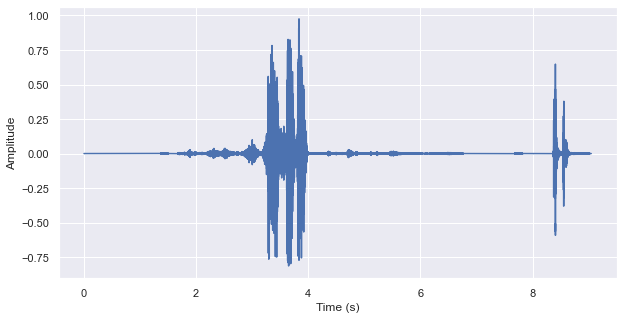

In [4]:
def plot_audio(audio_data, fe):
    # Intervalle de temps entre deux points.
    dt= 1/fe 
    # Variable de temps en seconde.
    t = dt*np.arange(len(audio_data)) 
    plt.plot(t, audio_data)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
## Insérez votre code ici

plt.figure(figsize = (10,5))
plot_audio(audio, fe)

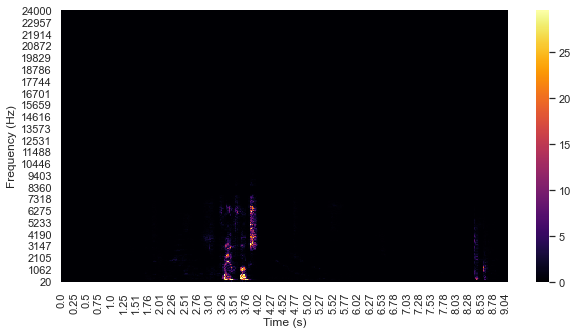

In [5]:
def spectrogram(audio, fe, dt):
    return np.abs(librosa.stft(audio, 
                        n_fft = int(dt*fe),
                       hop_length = int(dt*fe)
                       ))

def plot_spectrogram(audio, fe, dt=0.025):
    im = spectrogram(audio, fe, dt)
    sns.heatmap(np.rot90(im.T), cmap='inferno', vmin=0, vmax=np.max(im)/3)
    loc, labels = plt.xticks()
    l = np.round((loc-loc.min())*len(audio)/fe/loc.max(), 2)
    plt.xticks(loc, l)
    loc, labels = plt.yticks()
    l = np.array(loc[::-1]*fe/2/loc.max(), dtype=int)
    plt.yticks(loc, l)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    
plt.figure(figsize=(10, 5))
plot_spectrogram(audio,fe)  

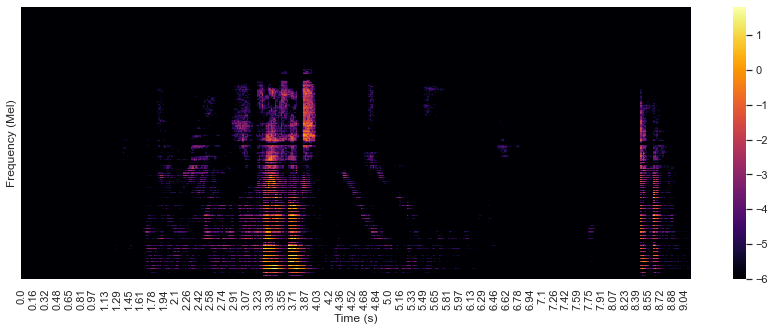

In [28]:
def logMelSpectrogram(audio, fe, dt):
    # Spectrogram
    stfts = np.abs(librosa.stft(audio,
                        n_fft = int(dt*fe),
                        hop_length = int(dt*fe),
                        center = True
                        )).T
    num_spectrogram_bins = stfts.shape[-1]
    # MEL filter
    linear_to_mel_weight_matrix = librosa.filters.mel(
                                sr=fe,
                                n_fft=int(dt*fe) + 1,
                                n_mels=num_spectrogram_bins,
                    ).T

    # Apply the filter to the spectrogram
    mel_spectrograms = np.tensordot(
                stfts,
                linear_to_mel_weight_matrix,
                1
            )
    return np.log(mel_spectrograms + 1e-6)


def plot_logMelSpectrogram(audio, fe, dt=0.025):
    sns.heatmap(np.rot90(logMelSpectrogram(audio, fe, dt)), cmap='inferno', vmin = -6)
    loc, labels = plt.xticks()
    l = np.round((loc-loc.min())*len(audio)/fe/loc.max(), 2)
    plt.xticks(loc, l)
    plt.yticks([])
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Mel)")
    
plt.figure(figsize=(15,5))
plot_logMelSpectrogram(audio, fe, 0.02)

In [12]:
# Reconstitituer un dataframe ressemblant le plus possible à celui utilisé par Lamia (challenge Kaggle)
df = pd.read_csv('datasets/cv-sw-valid.tsv', sep="\t")
df.dataframeName = 'datasets/cv-sw-valid.tsv'
df

,client_id,path,sentence,up_votes,down_votes,age,gender,accent,locale,segment
0,05a87054181791477a299a08fc35a6ff0c53250cae313e...,common_voice_fr_22108074.mp3,zéro,2,0,NaN,NaN,NaN,fr,Singleword Benchmark
1,06c9c9e703dfa759edf4836936b42a07afd1021cedb06c...,common_voice_fr_22098482.mp3,trois,2,0,NaN,NaN,NaN,fr,Singleword Benchmark
2,07a7db773acd156dd0b7fdc32f6b5eda9b32ffa1b3aee7...,common_voice_fr_21955578.mp3,quatre,6,3,NaN,NaN,NaN,fr,Singleword Benchmark
3,0dde0df66454b490f5b9514acb4bb48dc91bbe740254b0...,common_voice_fr_22379668.mp3,neuf,2,0,fourties,male,france,fr,Singleword Benchmark
4,0eb85c7dcb9b7ca2caec05a0dbbf6ee983cfab19164dac...,common_voice_fr_22157149.mp3,Firefox,3,1,NaN,NaN,NaN,fr,Singleword Benchmark
...,...,...,...,...,...,...,...,...,...,...
16462,ffd847388e93bcd91855b2a4de02c87c29ed9df053da9c...,common_voice_fr_21954620.mp3,trois,3,0,NaN,NaN,NaN,fr,Singleword Benchmark
16463,ffd847388e93bcd91855b2a4de02c87c29ed9df053da9c...,common_voice_fr_21954648.mp3,sept,3,0,NaN,NaN,NaN,fr,Singleword Benchmark
16464,ffd847388e93bcd91855b2a4de02c87c29ed9df053da9c...,common_voice_fr_21954649.mp3,non,4,0,NaN,NaN,NaN,fr,Singleword Benchmark
16465,ffd847388e93bcd91855b2a4de02c87c29ed9df053da9c...,common_voice_fr_21954650.mp3,zéro,3,0,NaN,NaN,NaN,fr,Singleword Benchmark


In [14]:
train = pd.concat([df.path, df.sentence], axis = 1)
train = train.rename(columns={'path': 'file', 'sentence': 'label'})
train['file'] = "datasets/cv-sw/" + train['file']
train

,file,label
0,datasets/cv-sw/common_voice_fr_22108074.mp3,zéro
1,datasets/cv-sw/common_voice_fr_22098482.mp3,trois
2,datasets/cv-sw/common_voice_fr_21955578.mp3,quatre
3,datasets/cv-sw/common_voice_fr_22379668.mp3,neuf
4,datasets/cv-sw/common_voice_fr_22157149.mp3,Firefox
...,...,...
16462,datasets/cv-sw/common_voice_fr_21954620.mp3,trois
16463,datasets/cv-sw/common_voice_fr_21954648.mp3,sept
16464,datasets/cv-sw/common_voice_fr_21954649.mp3,non
16465,datasets/cv-sw/common_voice_fr_21954650.mp3,zéro


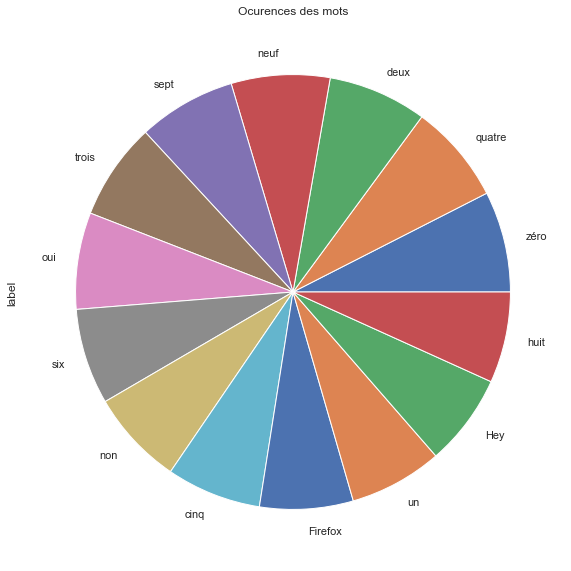

In [15]:
plt.figure(figsize=(10, 10))
plt.title("Ocurences des mots")
train['label'].value_counts(normalize = True).plot(kind = 'pie')

In [17]:
train['label'].value_counts()

zéro       1236
quatre     1219
deux       1210
neuf       1208
sept       1199
trois      1189
oui        1183
six        1174
non        1164
cinq       1161
Firefox    1144
un         1142
Hey        1124
huit       1114
Name: label, dtype: int64

In [18]:
train['label'] = train['label'].replace(['neuf','Hey','oui','Firefox','trois','sept','zéro','non','six','huit', 'quatre','cinq', 'un','deux'], list(range(14)))


# correspondances mots/numéro
words = {
    'neuf':    0,                                             
    'Hey':     1,
    'oui':     2,
    'Firefox': 3,
    'trois':   4,
    'sept':    5,
    'zéro':    6,
    'non':     7,
    'six':     8,
    'huit':    9,
    'quatre': 10,
    'cinq':   11,
    'un':     12,
    'deux':   13
}


In [19]:
train

,file,label
0,datasets/cv-sw/common_voice_fr_22108074.mp3,6
1,datasets/cv-sw/common_voice_fr_22098482.mp3,4
2,datasets/cv-sw/common_voice_fr_21955578.mp3,10
3,datasets/cv-sw/common_voice_fr_22379668.mp3,0
4,datasets/cv-sw/common_voice_fr_22157149.mp3,3
...,...,...
16462,datasets/cv-sw/common_voice_fr_21954620.mp3,4
16463,datasets/cv-sw/common_voice_fr_21954648.mp3,5
16464,datasets/cv-sw/common_voice_fr_21954649.mp3,7
16465,datasets/cv-sw/common_voice_fr_21954650.mp3,6


In [20]:
X_train_path, X_test_path, Y_train, Y_test = train_test_split(train.file, train["label"], test_size=0.2, random_state=1234, stratify=train["label"])

In [21]:
# Mise au format array()
Y_train = Y_train.values # array([ 3, 19,  1, ...,  6, 16, 27])
Y_test = Y_test.values

In [84]:
def load_rawdata(X_path, dt=0.02, T_max=2):
    all_data = []
    all_path =[]
    SR = params['sampling_rate']
    size_ =len(X_path)
    with tqdm(total=size_) as pbar:
        for index in (range(size_)):
            pbar.update(1)
            audio_path = X_path[index]
            # Load the audio file
            fname = Path(audio_path)
            if fname.exists() == True :
                # print(audio)
                X, sample_rate = librosa.load(audio_path, mono = True, sr = None)
                # Resampling at 16000 Hz
                X = librosa.resample(X, sample_rate, SR)
                all_data.append(X)
                
    return all_data


def ProcessRawData(raw_data):
    T_max = params['max_audio_length']
    fe = params['sampling_rate']
    size_ = len(raw_data)
    k = 0
    X_audio=[]
    with tqdm(total=size_) as pbar:
        for i in range(size_):
            pbar.update(1)
            k += 1
            data = raw_data[i]
            if len(data) >= T_max*fe: 
                # Shape invalid: truncate pour le coup
                data = data[:int(T_max*fe)]
            # After this transformation add zeroes to have the right shape
            else :
                data = np.concatenate([data, np.zeros(int(T_max*fe - len(data)))])
            X_audio.append(data)
        return X_audio


def Convert2logMelSpectrogram(X_data):
    fe = params['sampling_rate']
    X_audio=[]
    size_ =len(X_data)
    with tqdm(total=size_) as pbar:
        for i in range(size_):
            pbar.update(1)
            # Apply the logMelSpectrogram function.    
            spectre_audio = logMelSpectrogram(X_data[i], fe, DT)
            X_audio.append(spectre_audio)
        return np.array(X_audio)   
    
    


In [70]:
X_raw_train = load_rawdata(np.array(X_train_path))

100%|██████████| 13173/13173 [28:07<00:00,  7.81it/s]


In [64]:
X_raw_test = load_rawdata(np.array(X_test_path))

100%|██████████| 3294/3294 [06:29<00:00,  8.46it/s]


In [71]:
X_raw_train = ProcessRawData(X_raw_train)

100%|██████████| 13173/13173 [00:06<00:00, 2007.58it/s]


In [65]:
X_raw_test = ProcessRawData(X_raw_test)

100%|██████████| 3294/3294 [00:01<00:00, 2063.72it/s]


In [72]:
X_raw_train = np.array(X_raw_train)

In [68]:
X_raw_test = np.array(X_raw_test)

In [73]:
X_raw_train.shape

(13173, 80000)

In [69]:
X_raw_test.shape

(3294, 80000)

In [82]:
X_train = Convert2logMelSpectrogram(X_raw_train)

100%|██████████| 13173/13173 [01:17<00:00, 170.12it/s]


In [79]:
X_test = Convert2logMelSpectrogram(X_raw_test)

100%|██████████| 3294/3294 [00:13<00:00, 243.07it/s]


In [83]:
X_train.shape

(13173, 251, 161)

In [81]:
X_test.shape

(3294, 251, 161)

In [85]:
X_train.shape[1:]

(251, 161)

# Modélisation

In [86]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, LeakyReLU, Flatten, GlobalAveragePooling1D
from keras.optimizers import Adam

num_classes = 14

model = Sequential()
# Part 1
model.add(Conv1D(64, kernel_size=5, dilation_rate=2, input_shape=X_train.shape[1:]))
model.add(Dropout(0.2))
model.add(LeakyReLU())
# Part 2
model.add(Conv1D(128, kernel_size=5, dilation_rate=2))
model.add(Dropout(0.2))
model.add(LeakyReLU())
# Part 3
model.add(Conv1D(256, kernel_size=5, dilation_rate=2))
model.add(Dropout(0.2))
model.add(LeakyReLU())
model.add(GlobalAveragePooling1D())
# Classification part
model.add(Dense(256))
model.add(Dropout(0.2))
model.add(LeakyReLU())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 243, 64)           51584     
_________________________________________________________________
dropout (Dropout)            (None, 243, 64)           0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 243, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 235, 128)          41088     
_________________________________________________________________
dropout_1 (Dropout)          (None, 235, 128)          0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 235, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 227, 256)          1

# Entraînement

In [87]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), verbose=1, batch_size=32, epochs=50)

Epoch 1/50
412/412 [==============================] - 39s 94ms/step - loss: 2.8270 - accuracy: 0.0789 - val_loss: 2.6708 - val_accuracy: 0.0698
Epoch 2/50
412/412 [==============================] - 35s 86ms/step - loss: 2.6626 - accuracy: 0.1029 - val_loss: 2.6181 - val_accuracy: 0.1078
Epoch 3/50
412/412 [==============================] - 35s 85ms/step - loss: 2.4590 - accuracy: 0.1831 - val_loss: 2.0111 - val_accuracy: 0.3443
Epoch 4/50
412/412 [==============================] - 34s 84ms/step - loss: 1.7121 - accuracy: 0.4281 - val_loss: 1.2433 - val_accuracy: 0.6035
Epoch 5/50
412/412 [==============================] - 35s 85ms/step - loss: 1.0651 - accuracy: 0.6456 - val_loss: 0.7865 - val_accuracy: 0.7468
Epoch 6/50
412/412 [==============================] - 37s 89ms/step - loss: 0.8099 - accuracy: 0.7378 - val_loss: 0.6891 - val_accuracy: 0.7787
Epoch 7/50
412/412 [==============================] - 36s 88ms/step - loss: 0.6597 - accuracy: 0.7889 - val_loss: 0.4384 - val_accuracy:

# Sauvegarde des fichiers

In [88]:
model.save('model/cv-sw/cv_singleword.h5')

In [89]:
model.save_weights('model/cv-sw/cv_singleword_weights')

# Evaluation

In [90]:
from sklearn.metrics import classification_report
test_pred = model.predict(X_test)

test_pred_class = test_pred.argmax(axis = 1)


print(classification_report(Y_test, test_pred_class))

#test_pred

              precision    recall  f1-score   support

           0       0.98      0.84      0.91       242
           1       0.96      0.96      0.96       225
           2       0.95      0.92      0.94       236
           3       0.99      0.93      0.95       229
           4       0.98      0.95      0.97       238
           5       0.96      0.91      0.94       240
           6       0.98      0.98      0.98       247
           7       0.85      0.97      0.90       233
           8       0.98      0.93      0.95       235
           9       0.92      0.95      0.93       223
          10       0.97      0.87      0.92       244
          11       0.82      0.95      0.88       232
          12       0.87      0.96      0.91       228
          13       0.90      0.95      0.92       242

    accuracy                           0.93      3294
   macro avg       0.94      0.93      0.93      3294
weighted avg       0.94      0.93      0.93      3294



In [91]:
from sklearn.metrics import confusion_matrix

pd.crosstab(Y_test, test_pred_class, rownames = ['Classes Réelles'], colnames = ['Classes prédites'])

Classes prédites,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Classes Réelles,,,,,,,,,,,,,,
0,204,0,0,0,0,0,0,24,0,1,1,0,2,10
1,0,215,1,0,0,0,0,2,1,1,1,2,1,1
2,0,3,218,0,0,0,0,2,0,9,0,2,2,0
3,1,1,0,212,1,1,1,1,0,1,4,6,0,0
4,0,0,0,0,227,0,0,3,0,0,0,4,3,1
5,0,1,0,0,0,218,1,0,2,0,0,15,2,1
6,0,0,0,0,0,1,242,2,2,0,0,0,0,0
7,1,0,0,0,2,0,0,225,0,1,0,0,2,2
8,0,2,0,1,0,0,0,1,219,1,0,6,0,5


# Prédiction

In [118]:
dataT, feT = load_audio('datasets/cv-sw/common_voice_fr_22157149.mp3')
dt=0.02
T_max=5
            
# For the audio > T_max : Use just the fist T_max seconde, to have the right shape. 
if len(dataT)>= T_max*feT:
    dataT = dataT[:int(T_max*feT)]        
        # For the audio < T_max : Add in the signal a zeros vector, to have the right shape.
else :
    dataT = np.concatenate([dataT, np.zeros(int(T_max*feT - len(dataT)))])
            


In [119]:
Audio(dataT, rate = feT)

In [112]:
a_path = []
a_path.append('datasets/cv-sw/common_voice_fr_22157149.mp3')

In [113]:
a_path[0] 

'datasets/cv-sw/common_voice_fr_22157149.mp3'

In [114]:
a_data = load_rawdata(np.array(a_path))

100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


In [115]:
a_data = ProcessRawData(a_data)

100%|██████████| 1/1 [00:00<00:00, 4350.94it/s]


In [120]:
a_data = np.array(a_data)

In [121]:
a_mel = Convert2logMelSpectrogram(a_data)

100%|██████████| 1/1 [00:00<00:00, 187.90it/s]


In [122]:
a_mel.shape[1:]

(251, 161)

In [123]:
spectre_audio = a_mel.reshape(1,251, 161)

In [128]:
spectre_audio.shape

(1, 251, 161)

In [126]:
def displaylabel(prediction):
    listOfKeys = [key  for (key, value) in words.items() if value == prediction]
    return listOfKeys[0]

In [127]:
prediction = model.predict(spectre_audio).argmax()
displaylabel(prediction)

'Firefox'